# Exploratory Data Analysis Notebook

## What is Pneuomonia?

- Pneumonia is an infection that <b>inflames air sacs</b> in one or both lungs, which may fill with fluid.
- With pneumonia, the <b>air sacs may fill with fluid or pus.</b> 
- The infection can be <b>life-threatening</b> to anyone, but particularly to infants, children and people over 65.

## What Exactly are we Predicting?

- The objective is to build an algorithm that can <b>detect visual signals for pneumonia</b> in medical images. 
- We do so by <b>predicting bounding boxes</b> around areas of the lung. 
- Samples <b>without</b> bounding boxes are <b>negative</b> and contain no definitive evidence of pneumonia. 
- Samples <b>with</b> bounding boxes <b>indicate evidence of pneumonia</b>.

## Format of Data

- <b><i>patientId_</i></b>- A patientId. Each patientId corresponds to a unique image.
- <b><i>x_</i></b> - the upper-left x coordinate of the bounding box.
- <b><i>y_</i></b> - the upper-left y coordinate of the bounding box.
- <b><i>width_</i></b> - the width of the bounding box.
- <b><i>height_</i></b> - the height of the bounding box.
- <b><i>Target_</i></b> - the binary Target, indicating whether this sample has evidence of pneumonia. (1 = true, 0 = false)

## Notes

- A pneumonia opacity is a part of the lungs that looks darker on a radiograph and has a shape that indicates that pneumonia is (or may be) present.
- Since the goal is to detect & then draw a bounding box on each pneumonia opacities (where each image can have 0 or many), and the training set is already classified:
    - It can be analysed as a supervised learning statistical multilabel classification


##### Classification Algorithms that can adapt to multi-label classification

- Boosting
- K nearest neighbours
- Decision Trees
- Kernel Methods
- Neural Networks

In [197]:
# Imports
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import pydicom
import pylab as pl
%matplotlib inline

import os
from os import listdir
from os.path import isfile, join

In [14]:
pathLabels = "/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_train_labels.csv"
classInfo = "/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_detailed_class_info.csv"

labels = pd.read_csv(pathLabels)
classInfo = pd.read_csv(classInfo)

### Lets merge the classInfo & labels

In [32]:
merged = pd.merge(left = classInfo, right = labels, how = 'left', on = 'patientId') # Merge
merged = merged.drop_duplicates() # Remove duplicates

merged.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [237]:
# How many unique features?
print(f"Unique features: \n{merged.nunique()}")

Unique features: 
patientId    26684
class            3
x              748
y              726
width          351
height         725
Target           2
dtype: int64


In [247]:
neg, pos = merged["Target"].value_counts()

print(f'How many people have pneumonia vs do not: \n{merged["Target"].value_counts()}\n')

print(f'This is roughly {round(pos/(pos+neg)*100, 2)}% having pneumonia within this training data')

How many people have pneumonia vs do not: 
0    20672
1     9555
Name: Target, dtype: int64

This is roughly 31.61% having pneumonia within this training data


###### We can see that over 20,000 people are classified as not having pneumonia, whereas around 10,000 people do

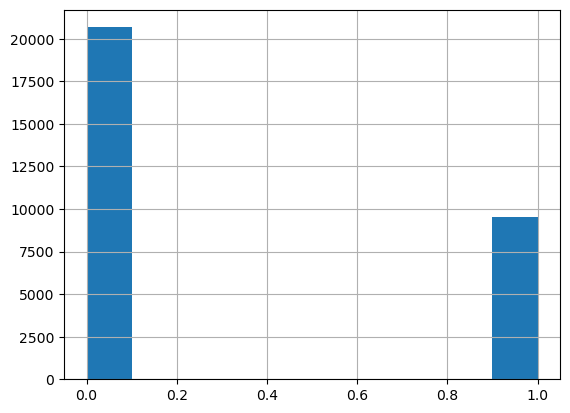

In [36]:
# See how many people with pneumonia vs non-pneumonia
merged['Target'].hist();

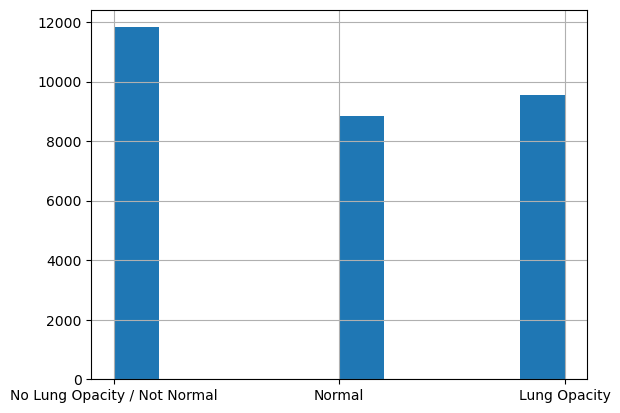

In [38]:
# Look at the amounts in each of the different classes
merged['class'].hist();

###### It seems that the amount is spread evenly between the 3 classes
###### with roughly 2/3s being either classified as Normal or no lung opacity/not normal

# Some Numerical Analysis

### Check out pneumonia classifying boxes

In [56]:
boxNums = merged.dropna()[['x', 'y', 'width', 'height']].copy() # Make a copy of just the boxes

# Calculate x2 & y2 coordinates
boxNums['x2'] = boxNums['x'] + boxNums['width']
boxNums['y2'] = boxNums['y'] + boxNums['height']

# Calculate x2 & y2 centres
boxNums['xCentre'] = boxNums['x'] + boxNums['width']/2
boxNums['yCentre'] = boxNums['y'] + boxNums['height']/2

# Calculate area of the box
boxNums['boxArea'] = boxNums['width'] * boxNums['height']

In [55]:
boxNums.head()

,x,y,width,height,x2,y2,xCentre,yCentre,boxArea
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
10,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
11,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
18,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


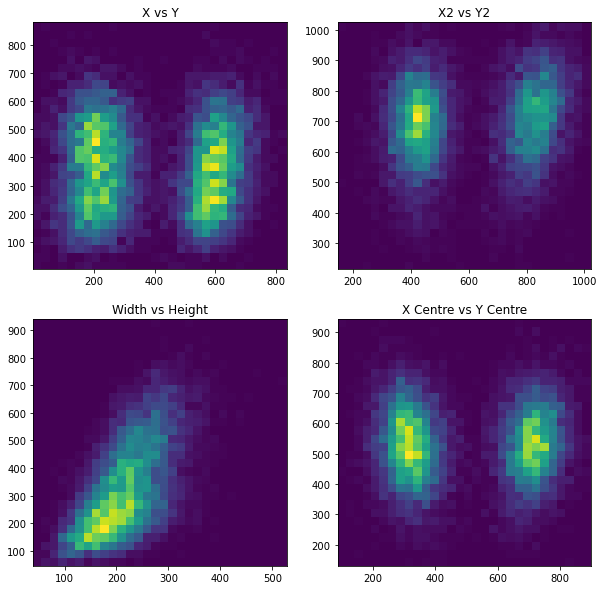

In [125]:
# Look at the correlations between x, y, x2, y2, width, height and the centres

pairs = [(boxNums['x'], boxNums['y']), (boxNums['x2'], boxNums['y2']), (boxNums['width'], boxNums['height']), 
         (boxNums['xCentre'], boxNums['yCentre'])]

axis = [(0, 0), (0, 1), (1, 0), (1,1)]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    axs[axis[i][0], axis[i][1]].hist2d(pairs[i][0], pairs[i][1], bins=30)

# Set titles
axs[0,0].set_title('X vs Y')
axs[0,1].set_title('X2 vs Y2')
axs[1,0].set_title('Width vs Height')
axs[1,1].set_title('X Centre vs Y Centre')

plt.show()    

###### Taking a look at the heatmap, we can see that the centres seems to have more density for x, x2 and y, y2

In [132]:
merged.iloc[4]

patientId    00436515-870c-4b36-a041-de91049b9ab4
class                                Lung Opacity
x                                           264.0
y                                           152.0
width                                       213.0
height                                      379.0
Target                                          1
Name: 4, dtype: object

###### Important Note: A given patientId may have multiple boxes if more than one area of pneumonia is detected (see below for example images).

### A brief overview of DICOM files

- Medical images are stored in a special format known as DICOM
- They contain a combination of both meta data and pixel data
- We use a python library called pydicom to access these image files

<br>

To use pydicom:
1. Find the dicom file for a given patientID
2. Then use pydicom.read_file()

In [156]:
# Get the first patients id
patient1 = merged['patientId'][4]
patient1

'00436515-870c-4b36-a041-de91049b9ab4'

In [157]:
imgsPath = "/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_train_images/"

dcmFile = f"{imgsPath}{patient1}.dcm"
dcmData = pydicom.read_file(dcmFile)

(-0.5, 1023.5, 1023.5, -0.5)

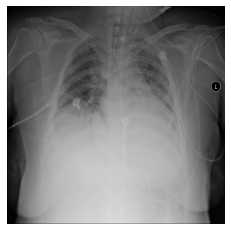

In [158]:
# Show image of this patient
img = dcmData.pixel_array # Get the pixel array

pl.imshow(img, cmap=pl.cm.gist_gray) # Plot
pl.axis('off') # Remove axis

In [166]:
p = merged.loc[merged['patientId'] == patient1]
p

,patientId,class,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1


###### We can see that this particular patient (patient #5) has pneumonia, and has 2 entries, with 2 different boxes

### We want to create a Data parser to group a patients boxes with its image

In [218]:
def parseData(df):

    newData = {}
    
    for n, row in df.iterrows():
        
        patientID = row['patientId'] # Initialise patient
        
        # If patient is not in the dict, add them
        if patientID not in newData:
            newData[patientID] = {
                'dicom': f"{imgsPath}{patientID}.dcm",
                'classifier': row['Target'],
                'boxes': []}

        # Add box if the patient has pneumonia
        if newData[patientID]['classifier'] == 1:
            newData[patientID]['boxes'].append([row['x'], row['y'], row['width'], row['height']])

    return newData

In [234]:
parsedData = parseData(merged)

# Check patient 1 which we know has pneumonia
parsedData[patient1]

{'dicom': '/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'classifier': 1,
 'boxes': [[264.0, 152.0, 213.0, 379.0], [562.0, 152.0, 256.0, 453.0]]}

###### We can see that we have saved the file path, the classifier and the array of boxes for that person

###### Now check someone we know that doesnt have pneumonia

In [224]:
parsed[merged['patientId'][0]]

{'dicom': '/Users/Bozinovski/Desktop/UNSW/21t2/COMP9417/Project/Data/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'classifier': 0,
 'boxes': []}

###### Create a function that allows us to draw the boxes over the images

In [231]:
"""
Credit for @peterchang77 on kaggle for these 2 functions
"""

# This function will allow us to overlay a box
def overlayBox(im, box, rgb, stroke=1):

    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    x, y, width, height = box
    y2 = y + height
    x2 = x + width

    im[y:y + stroke, x:x2] = rgb
    im[y2:y2 + stroke, x:x2] = rgb
    im[y:y2, x:x + stroke] = rgb
    im[y:y2, x2:x2 + stroke] = rgb

    return im

def drawBox(data):
    
    d = pydicom.read_file(data['dicom']) # Open and read the file
    im = d.pixel_array

    # Convert to 3 RGB
    im = np.stack([im] * 3, axis=2)

    # Add the boxes with random colours
    for box in data['boxes']:
        
        rgb = np.floor(np.random.rand(3) * 256).astype('int') # Get rgb
        
        im = overlayBox(im=im, box=box, rgb=rgb, stroke=6) # Overlay the box

    pl.imshow(im, cmap=pl.cm.gist_gray) # Show the image
    pl.axis('off') # Remove axis


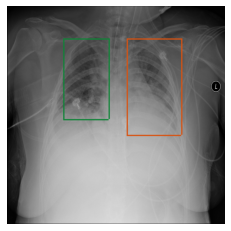

In [233]:
drawBox(parsedData[patient1])

###### We can see the dark opacities in the image were boxed, indicating the pnemonia